In [14]:
import os
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import KFold


In [2]:
cd = os.getcwd()
path_raw_data = os.path.join(cd, r"data\TiMeS_Raw_Data2023.xlsx")
file_paths = [
    r".\data\Raw_MissingDataImputed\TiMeS_matrix_mdImputed_allT1.xlsx",
    r".\data\Raw_MissingDataImputed\TiMeS_matrix_mdImputed_allT2.xlsx",
    r".\data\Raw_MissingDataImputed\TiMeS_matrix_mdImputed_allT3.xlsx",
    r".\data\Raw_MissingDataImputed\TiMeS_matrix_mdImputed_allT4.xlsx",
]

In [3]:
columns_to_keep = [
    "Patient",
    "Fugl.Meyer_affected_UPPER_EXTREMITY",
    "Ashworth_affected",
    "Fugl.Meyer_unaffected_UPPER_EXTREMITY",
    "Fugl.Meyer_unaffected_WRIST",
    "Fugl.Meyer_unaffected_HAND",
    "Ashworth_unaffected",
    "X9HPT_unaffected",
    "RASP_TOTAL_affected",
    "RASP_TOTAL_unaffected",
    "MOCA_visuo.spatial.executive",
    "MOCA_denomination",
    "MOCA_attention_tot",
    "MOCA_language_tot",
    "MOCA_abstraction",
    "MOCA_memory"]
print(len(columns_to_keep))

16


In [ ]:
dataframes = []
for path in file_paths:
    df = pd.read_excel(path) 
    filtered_df = df[columns_to_keep] 
    dataframes.append(filtered_df) 


In [ ]:
sessions = ["T1", "T2", "T3", "T4"]
merged_df = None

for session, df in zip(sessions, dataframes):
    
    df = df.rename(
        columns={col: f"{col}_{session}" for col in df.columns if col != "Patient"}
    )
    
    if merged_df is None:
        merged_df = df
    else:
        merged_df = pd.merge(merged_df, df, on="Patient", how="outer")

merged_df.head()


,Patient,Fugl.Meyer_affected_UPPER_EXTREMITY_T1,Ashworth_affected_T1,Fugl.Meyer_unaffected_UPPER_EXTREMITY_T1,Fugl.Meyer_unaffected_WRIST_T1,Fugl.Meyer_unaffected_HAND_T1,Ashworth_unaffected_T1,X9HPT_unaffected_T1,RASP_TOTAL_affected_T1,RASP_TOTAL_unaffected_T1,...,Ashworth_unaffected_T4,X9HPT_unaffected_T4,RASP_TOTAL_affected_T4,RASP_TOTAL_unaffected_T4,MOCA_visuo.spatial.executive_T4,MOCA_denomination_T4,MOCA_attention_tot_T4,MOCA_language_tot_T4,MOCA_abstraction_T4,MOCA_memory_T4
0,P001,30.0,1.593366,30.0,10.0,14.0,-0.918470,21.0,174.417918,170.697142,...,0.0,19.16,179.0,179.0,5.0,3.0,6.0,3.0,2.0,2.0
1,P002,30.0,1.793385,30.0,10.0,13.0,0.428554,22.0,173.003930,173.224818,...,1.0,20.62,174.0,175.0,5.0,3.0,5.0,3.0,1.0,5.0
2,P003,30.0,2.074027,30.0,10.0,14.0,-0.738813,20.0,171.528771,168.814602,...,0.0,17.78,173.0,178.0,3.0,3.0,6.0,1.0,1.0,3.0
3,P004,18.0,0.000000,2.0,8.0,14.0,0.000000,31.2,166.000000,167.000000,...,0.0,26.19,166.0,173.0,3.0,3.0,6.0,2.0,2.0,5.0
4,P005,30.0,6.000000,30.0,10.0,14.0,0.000000,26.8,170.000000,172.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# Enregistrement du DataFrame fusionné en fichier Excel
output_path = "./data/merged_dataframe.xlsx"
merged_df.to_excel(output_path, index=False)

print(f"Fichier Excel sauvegardé à : {output_path}")


Fichier Excel sauvegardé à : ./data/merged_dataframe.xlsx


In [ ]:
features = columns_to_keep.copy()
features.remove("Patient")
for feature in features:
    
    feature_T1 = f"{feature}_T1"
    feature_T2 = f"{feature}_T2"
    feature_T3 = f"{feature}_T3"
    new_col_name = f"{feature}_change"

    merged_df[new_col_name] = merged_df.apply(
        lambda row:
        (row[feature_T3] - row[feature_T1]) / row[feature_T1]
        if not pd.isna(row[feature_T1]) and row[feature_T1] != 0 else
        (row[feature_T3] - row[feature_T2]) / row[feature_T2]
        if not pd.isna(row[feature_T2]) and row[feature_T2] != 0 else
        np.nan,
        axis=1
    )

output_path = "./data/merged_dataframe.xlsx"
merged_df.to_excel(output_path, index=False)
print(f"Fichier sauvegardé à : {output_path}")


Fichier sauvegardé à : ./data/merged_dataframe.xlsx


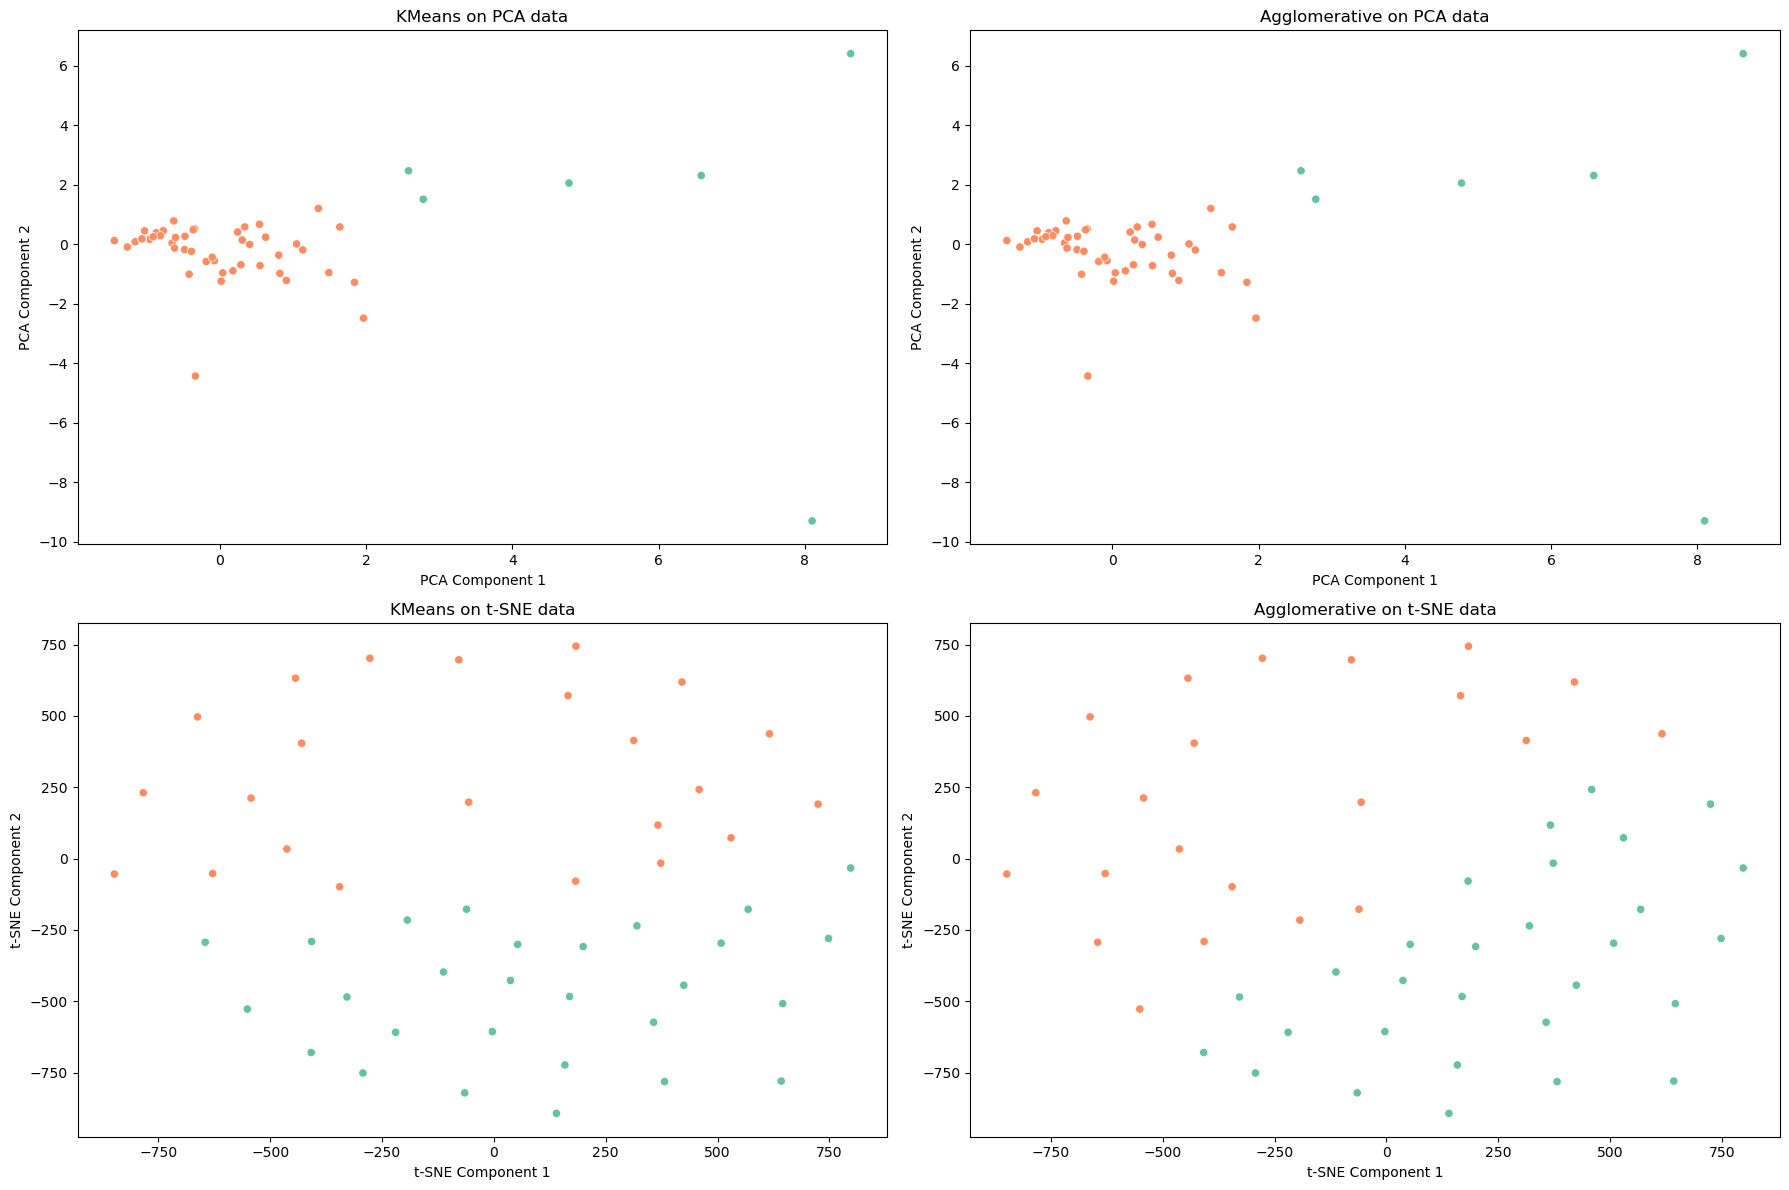

In [13]:

change_columns = [col for col in merged_df.columns if col.endswith('_change')]
change_data = merged_df[change_columns]

change_data = change_data.fillna(0)

scaler = StandardScaler()
normalized_data = scaler.fit_transform(change_data)


pca = PCA(n_components=2)
pca_reduced_data = pca.fit_transform(normalized_data)

tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_reduced_data = tsne.fit_transform(normalized_data)


reduced_datasets = [("PCA", pca_reduced_data), ("t-SNE", tsne_reduced_data)]
clustering_algorithms = {
    "KMeans": KMeans(n_clusters=2, random_state=42),
    "Agglomerative": AgglomerativeClustering(n_clusters=2, linkage='ward'),
}

fig, axes = plt.subplots(len(reduced_datasets), len(clustering_algorithms), figsize=(18, 12))

for i, (name, reduced_data) in enumerate(reduced_datasets):
    for j, (algo_name, algo) in enumerate(clustering_algorithms.items()):
        cluster_labels = algo.fit_predict(reduced_data)
        
        reduced_df = pd.DataFrame(reduced_data, columns=[f'{name}_1', f'{name}_2'])
        reduced_df['Cluster'] = cluster_labels
        
        sns.scatterplot(
            ax=axes[i, j],
            data=reduced_df,
            x=f'{name}_1', 
            y=f'{name}_2',
            hue='Cluster',
            palette='Set2',
            legend=None
        )
        axes[i, j].set_title(f"{algo_name} on {name} data")
        axes[i, j].set_xlabel(f"{name} Component 1")
        axes[i, j].set_ylabel(f"{name} Component 2")

plt.tight_layout()
plt.show()

In [9]:
non_nan_counts = merged_df[change_columns].notna().sum()

print("Number of patients without NaN by column :")
print(non_nan_counts)

Number of patients without NaN by column :
Fugl.Meyer_affected_UPPER_EXTREMITY_change      48
Ashworth_affected_change                        30
Fugl.Meyer_unaffected_UPPER_EXTREMITY_change    50
Fugl.Meyer_unaffected_WRIST_change              50
Fugl.Meyer_unaffected_HAND_change               50
Ashworth_unaffected_change                      21
X9HPT_unaffected_change                         50
RASP_TOTAL_affected_change                      50
RASP_TOTAL_unaffected_change                    50
MOCA_visuo.spatial.executive_change             49
MOCA_denomination_change                        50
MOCA_attention_tot_change                       50
MOCA_language_tot_change                        47
MOCA_abstraction_change                         49
MOCA_memory_change                              44
dtype: int64


In [17]:
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

results = {algo_name: {name: [] for name, _ in reduced_datasets} for algo_name in clustering_algorithms.keys()}
print(results)
for train_idx, test_idx in kf.split(normalized_data):
    train_data, test_data = normalized_data[train_idx], normalized_data[test_idx]

    pca_train = pca.fit_transform(train_data)
    tsne_train = tsne.fit_transform(train_data)

    reduced_train_data = [("PCA", pca_train), ("t-SNE", tsne_train)]

    for name, reduced_data in reduced_train_data:
        for algo_name, algo in clustering_algorithms.items():
            cluster_labels = algo.fit_predict(reduced_data)

            silhouette = silhouette_score(reduced_data, cluster_labels)
            calinski_harabasz = calinski_harabasz_score(reduced_data, cluster_labels)

            results[algo_name][name].append((silhouette, calinski_harabasz))

for algo_name, reductions in results.items():
    print(f"Algorithm: {algo_name}")
    for reduction, scores in reductions.items():
        silhouettes, calinski_scores = zip(*scores)
        print(f"  Reduction: {reduction}")
        print(f"    Mean Silhouette Score: {np.mean(silhouettes):.4f} ± {np.std(silhouettes):.4f}")
        print(f"    Mean Calinski-Harabasz Score: {np.mean(calinski_scores):.4f} ± {np.std(calinski_scores):.4f}")


{'KMeans': {'PCA': [], 't-SNE': []}, 'Agglomerative': {'PCA': [], 't-SNE': []}}
Algorithm: KMeans
  Reduction: PCA
    Mean Silhouette Score: 0.7641 ± 0.0743
    Mean Calinski-Harabasz Score: 39.3304 ± 6.4789
  Reduction: t-SNE
    Mean Silhouette Score: 0.4076 ± 0.0294
    Mean Calinski-Harabasz Score: 28.6662 ± 5.3307
Algorithm: Agglomerative
  Reduction: PCA
    Mean Silhouette Score: 0.7980 ± 0.0489
    Mean Calinski-Harabasz Score: 51.4167 ± 1.7105
  Reduction: t-SNE
    Mean Silhouette Score: 0.4315 ± 0.0190
    Mean Calinski-Harabasz Score: 34.9643 ± 4.3694


Leave-One-Out Validation Results:

Reduction: PCA
  KMeans: Accuracy=86.75%, Precision=98.57%, Recall=87.34%, F1-Score=92.62%
  Agglomerative: Accuracy=97.59%, Precision=100.00%, Recall=97.47%, F1-Score=98.72%

Reduction: t-SNE
  KMeans: Accuracy=45.78%, Precision=55.77%, Recall=56.86%, F1-Score=56.31%
  Agglomerative: Accuracy=33.73%, Precision=12.96%, Recall=46.67%, F1-Score=20.29%


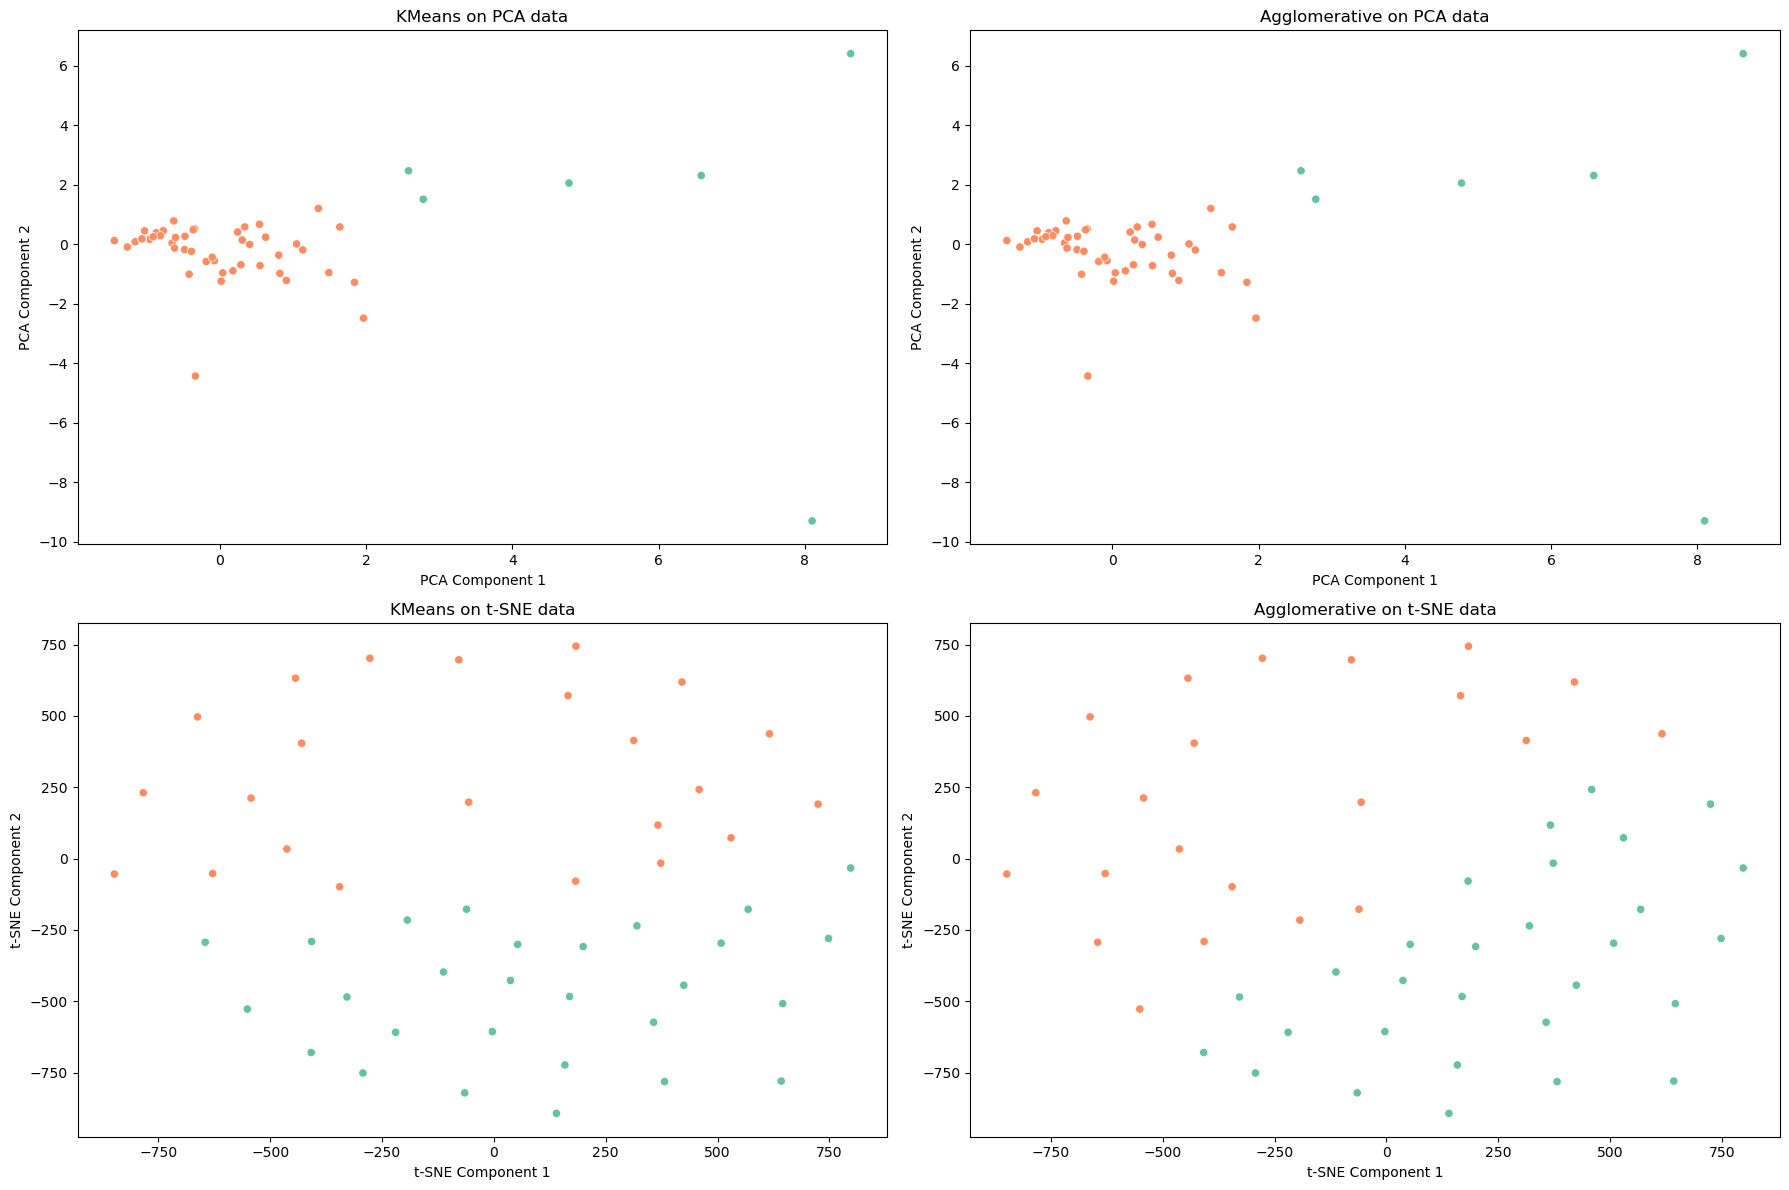

In [12]:
# Étape 1 : Prétraitement des données
change_columns = [col for col in merged_df.columns if col.endswith('_change')]
change_data = merged_df[change_columns].fillna(0)
scaler = StandardScaler()
normalized_data = scaler.fit_transform(change_data)

# Étape 2 : Réduction de dimension
pca = PCA(n_components=2)
pca_reduced_data = pca.fit_transform(normalized_data)

tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_reduced_data = tsne.fit_transform(normalized_data)

# Étape 3 : Initialisation des modèles et des données réduites
reduced_datasets = {
    "PCA": pca_reduced_data,
    "t-SNE": tsne_reduced_data
}
clustering_algorithms = {
    "KMeans": KMeans(n_clusters=2, random_state=42),
    "Agglomerative": AgglomerativeClustering(n_clusters=2, linkage='ward'),
}

# Étape 4 : Leave-One-Out Validation pour chaque combinaison
loo = LeaveOneOut()
results = {}

for reduction_name, reduced_data in reduced_datasets.items():
    results[reduction_name] = {}
    for algo_name, algo in clustering_algorithms.items():
        y_true = []
        y_pred = []
        for train_index, test_index in loo.split(reduced_data):
            train_data, test_data = reduced_data[train_index], reduced_data[test_index]
            
            # Ajuster le clustering
            algo.fit(train_data)
            
            # Prédiction
            if algo_name == "KMeans":
                test_label = algo.predict(test_data)[0]
            elif algo_name == "Agglomerative":
                # Re-cluster toute la matrice car Agglomerative n'a pas de méthode predict
                cluster_labels = algo.fit_predict(reduced_data)
                test_label = cluster_labels[test_index][0]
            
            # Référence basée sur le cluster de l'entraînement
            train_labels = algo.fit_predict(train_data)
            ref_label = train_labels[0]  # Le premier cluster de l'entraînement
            true_test_label = 1 if test_label == ref_label else 0
            
            # Stocker les labels réels et prédits
            y_true.append(true_test_label)
            y_pred.append(test_label)
        
        # Calcul des métriques globales
        accuracy = accuracy_score(y_true, y_pred) * 100
        precision = precision_score(y_true, y_pred, zero_division=0) * 100
        recall = recall_score(y_true, y_pred, zero_division=0) * 100
        f1 = f1_score(y_true, y_pred, zero_division=0) * 100

        results[reduction_name][algo_name] = {
            "Accuracy": accuracy,
            "Precision": precision,
            "Recall": recall,
            "F1-Score": f1,
        }

# Afficher les résultats
print("Leave-One-Out Validation Results:")
for reduction_name, algo_results in results.items():
    print(f"\nReduction: {reduction_name}")
    for algo_name, metrics in algo_results.items():
        print(
            f"  {algo_name}: "
            f"Accuracy={metrics['Accuracy']:.2f}%, "
            f"Precision={metrics['Precision']:.2f}%, "
            f"Recall={metrics['Recall']:.2f}%, "
            f"F1-Score={metrics['F1-Score']:.2f}%"
        )

# Étape 5 : Visualisation des clusters pour PCA et t-SNE
fig, axes = plt.subplots(len(reduced_datasets), len(clustering_algorithms), figsize=(18, 12))

for i, (reduction_name, reduced_data) in enumerate(reduced_datasets.items()):
    for j, (algo_name, algo) in enumerate(clustering_algorithms.items()):
        cluster_labels = algo.fit_predict(reduced_data)
        
        # Créer un DataFrame pour la visualisation
        reduced_df = pd.DataFrame(reduced_data, columns=[f'{reduction_name}_1', f'{reduction_name}_2'])
        reduced_df['Cluster'] = cluster_labels
        
        # Tracer les résultats
        sns.scatterplot(
            ax=axes[i, j],
            data=reduced_df,
            x=f'{reduction_name}_1', 
            y=f'{reduction_name}_2',
            hue='Cluster',
            palette='Set2',
            legend=None
        )
        axes[i, j].set_title(f"{algo_name} on {reduction_name} data")
        axes[i, j].set_xlabel(f"{reduction_name} Component 1")
        axes[i, j].set_ylabel(f"{reduction_name} Component 2")

plt.tight_layout()
plt.show()


In [15]:
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import silhouette_score, calinski_harabasz_score
import numpy as np

# Initialisation de Leave-One-Out
loo = LeaveOneOut()

# Préparer la structure pour enregistrer les résultats
results = {algo_name: {name: [] for name, _ in reduced_datasets} for algo_name in clustering_algorithms.keys()}

# Leave-One-Out validation
for train_idx, test_idx in loo.split(normalized_data):
    train_data, test_data = normalized_data[train_idx], normalized_data[test_idx]

    # Réduction de dimension pour les données d'entraînement
    pca_train = pca.fit_transform(train_data)
    tsne_train = tsne.fit_transform(train_data)

    reduced_train_data = [("PCA", pca_train), ("t-SNE", tsne_train)]

    for name, reduced_data in reduced_train_data:
        for algo_name, algo in clustering_algorithms.items():
            # Appliquer le clustering sur les données réduites
            cluster_labels = algo.fit_predict(reduced_data)

            # Calculer les métriques pour évaluer les clusters
            silhouette = silhouette_score(reduced_data, cluster_labels)
            calinski_harabasz = calinski_harabasz_score(reduced_data, cluster_labels)

            # Enregistrer les résultats
            results[algo_name][name].append((silhouette, calinski_harabasz))

# Calculer et afficher les scores moyens et leurs écarts-types
for algo_name, reductions in results.items():
    print(f"Algorithm: {algo_name}")
    for reduction, scores in reductions.items():
        silhouettes, calinski_scores = zip(*scores)
        print(f"  Reduction: {reduction}")
        print(f"    Mean Silhouette Score: {np.mean(silhouettes):.4f} ± {np.std(silhouettes):.4f}")
        print(f"    Mean Calinski-Harabasz Score: {np.mean(calinski_scores):.4f} ± {np.std(calinski_scores):.4f}")


Algorithm: KMeans
  Reduction: PCA
    Mean Silhouette Score: 0.7714 ± 0.0281
    Mean Calinski-Harabasz Score: 58.5592 ± 5.2328
  Reduction: t-SNE
    Mean Silhouette Score: 0.4354 ± 0.0300
    Mean Calinski-Harabasz Score: 43.4030 ± 8.5799
Algorithm: Agglomerative
  Reduction: PCA
    Mean Silhouette Score: 0.7789 ± 0.0150
    Mean Calinski-Harabasz Score: 60.7505 ± 1.3590
  Reduction: t-SNE
    Mean Silhouette Score: 0.4264 ± 0.0202
    Mean Calinski-Harabasz Score: 40.9362 ± 5.9069
